# Modeling and Simulation in Python

Chapter 3: Explain

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
def update_heads(system, n):
    system.heads += 1
def flip_until_tails(n, p):
    for i in range(n):
        if flip(p):
            update_heads(system, 1)
            print('heads')
        else:
            system.tails += 1
            print('tails')
            return
def add_pennies(sytem1, system2):
    heads = system1.heads + system2.heads
    tails = system1.tails + system2.tails
    total = System(heads=heads, tails=tails)
    return total
def run_simulation(p):
        system = System(tails=0, heads=0)
        flip_until_tails(p, system)
        return system
def run_simulations(p):
    penny_temp = run_simulation(p)
    for i in range(n-1):
        run_simulation(p)
        add_pennies(penny_temp, run_simulation(p))
        penny_temp = total
    return total
run_simulations(0.5)

TypeError: 'float' object cannot be interpreted as an integer

Pandas is a module that provides tools for reading and processing data.  The `read_html` reads a web page from a file or the Internet and creates one DataFrame for each table on the page.

In [3]:
from pandas import read_html

The data directory contains a downloaded copy of https://en.wikipedia.org/wiki/World_population_estimates

In [4]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

`tables` is a sequence of DataFrame objects.  We can select the DataFrame we want using the bracket operator.  The tables are numbered from 0, so `table2` is actually the third table on the page.

`head` selects the header and the first five rows.

In [5]:
table2 = tables[2]
table2.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`tail` selects the last five rows.

In [6]:
table2.tail()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
2011,6944055583,6.986951e+09,6997998760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,7022349283,7.057075e+09,7080072417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,7101027895,7.136796e+09,7162119434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,7178722893,7.238184e+09,7243784000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,7256490011,7.336435e+09,7349472000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Long column names are awkard to work with, but we can replace them with abbreviated names.

In [7]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Here's what the DataFrame looks like now.  

Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

In [8]:
table2

,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955,2782098943,NaN,2761650981,2.769074e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,2835299673,NaN,2811572031,2.822502e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,2891349717,NaN,2863042795,2.879934e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,2948137248,NaN,2916030167,2.939254e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can use dot notatio to select a column from a DataFrame.  The result is a Series.

In [9]:
census = table2.census
census

Year
1950    2557628654
1951    2594939877
1952    2636772306
1953    2682053389
1954    2730228104
1955    2782098943
1956    2835299673
1957    2891349717
1958    2948137248
1959    3000716593
1960    3043001508
1961    3083966929
1962    3140093217
1963    3209827882
1964    3281201306
1965    3350425793
1966    3420677923
1967    3490333715
1968    3562313822
1969    3637159050
1970    3712697742
1971    3790326948
1972    3866568653
1973    3942096442
1974    4016608813
1975    4089083233
1976    4160185010
1977    4232084578
1978    4304105753
1979    4379013942
           ...    
1986    4940571232
1987    5027200492
1988    5114557167
1989    5201440110
1990    5288955934
1991    5371585922
1992    5456136278
1993    5538268316
1994    5618682132
1995    5699202985
1996    5779440593
1997    5857972543
1998    5935213248
1999    6012074922
2000    6088571383
2001    6165219247
2002    6242016348
2003    6318590956
2004    6395699509
2005    6473044732
2006    6551263534
2007   

A Series object has two parts, `values` and `index`.

The `values` part is an array.

In [10]:
census.values

array([2557628654, 2594939877, 2636772306, 2682053389, 2730228104,
       2782098943, 2835299673, 2891349717, 2948137248, 3000716593,
       3043001508, 3083966929, 3140093217, 3209827882, 3281201306,
       3350425793, 3420677923, 3490333715, 3562313822, 3637159050,
       3712697742, 3790326948, 3866568653, 3942096442, 4016608813,
       4089083233, 4160185010, 4232084578, 4304105753, 4379013942,
       4451362735, 4534410125, 4614566561, 4695736743, 4774569391,
       4856462699, 4940571232, 5027200492, 5114557167, 5201440110,
       5288955934, 5371585922, 5456136278, 5538268316, 5618682132,
       5699202985, 5779440593, 5857972543, 5935213248, 6012074922,
       6088571383, 6165219247, 6242016348, 6318590956, 6395699509,
       6473044732, 6551263534, 6629913759, 6709049780, 6788214394,
       6866332358, 6944055583, 7022349283, 7101027895, 7178722893,
       7256490011], dtype=int64)

The `index` part is yet another kind of object, an `Int64Index`.

In [11]:
census.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
           dtype='int64', name='Year')

If you ever wonder what kind of object a variable refers to, you can use the `type` function.

The result indicates what type the object is, and the module where that type is defined.

DataFrame, Series, and Int64Index are defined by Pandas.

array is defined by NumPy.

In [12]:
type(table2)

pandas.core.frame.DataFrame

In [13]:
type(census)

pandas.core.series.Series

In [14]:
type(census.index)

pandas.core.indexes.numeric.Int64Index

In [15]:
type(census.values)

numpy.ndarray

This function plots the estimates generated by the US Censis and UN DESA, and labels the axes.

`1e9` is scientific notation for $1 \cdot 10^9$ or 1 billion.

In [16]:
def plot_estimates(table):
    """Plot world population estimates.
    
    table: DataFrame with columns 'un' and 'census'
    """
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)')

Now we can plot the estimates.

Saving figure to file chap03-fig01.pdf


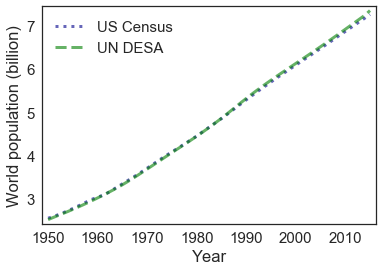

In [17]:
newfig()
plot_estimates(table2)
savefig('chap03-fig01.pdf')

From here on, we will work in units of billions.

In [18]:
un = table2.un / 1e9

In [19]:
census = table2.census / 1e9

This expression computes the elementwise differences between the series, then divides through by the UN value to produce relative errors, then finds the largest element.

So the largest relative error between the estimates is about 1.3%.

In [20]:
max(abs(census - un) / un) * 100

1.2862470293832287

**Exercise:** Break down that expression into smaller steps and display the intermediate results, to make sure you understand how it works.

Where in the series is the largest relative error between the two estimates, near the beginning or the end?

When I computed relative errors, I used `un` as the denominator.  But that was an arbitraty choice.  What happens if we use `census` instead?  How much difference does it make.

In [21]:
# Solution goes here
absolute_value = abs(census - un)

In [22]:
# Solution goes here
maximum = max(absolute_value / un)

In [23]:
# Solution goes here
maximum * 100

1.2862470293832287

In [24]:
# Solution goes here
max(abs(census - un) / census) * 100

1.2813631502151765

### Constant growth

We can select an element from a series using bracket notation and one of the elements from the index.  Here's the first element:

In [25]:
census[1950]

2.5576286540000002

And the last element.

In [26]:
census[2015]

7.2564900110000004

But we can get the first and last years from the index itself:

In [27]:
first_year = census.index[0]
last_year = census.index[-1]
first_year, last_year

(1950, 2015)

And use them to look up the first and last elements.

Then we can compute the average annual growth in billions of people per year.

In [28]:
total_growth = census[last_year] - census[first_year]
elapsed_time = last_year - first_year
annual_growth = total_growth / elapsed_time
annual_growth

0.07229017472307693

Now let's create a `TimeSeries` to contain values generated by a linear growth model.

In [29]:
results = TimeSeries()

Initially the Series is empty, but we can initialize it so the starting value, in 1950, is the 1950 population estimated by the US Census.

In [30]:
results[1950] = census[1950]
results

,value
1950,2.557629


After that, the population in the model grows by a constant amount each year.

In [31]:
for t in linrange(1950, 2015):
    results[t+1] = results[t] + annual_growth

Here's what the results looks like, compared to the actual data.

Saving figure to file chap03-fig02.pdf


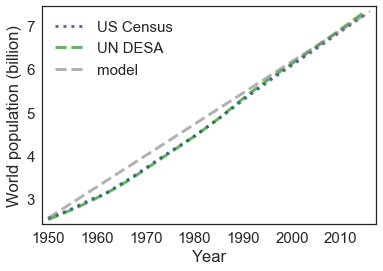

In [32]:
newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.pdf')

The model fits the data pretty well after 1990, but not so well before.

**Exercise:**  Try fitting the model using data from 1965 to the present, and see if that does a better job.

Hint: Copy the code from above and make a few changes.

Make sure your model starts in 1950, even though the estimated annual growth is based on later data.  You might have to shift the first value in the series up or down to match the data.

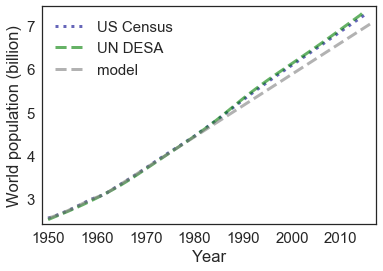

In [33]:
# Solution goes here
results[1965] = census[1965]
results
for t in linrange(1950, 1965):
    results[t] = census[t]
for t in linrange(1965, 2015):
    results[t+1] = results[t] + annual_growth
    
results[t+1] = results[t] + annual_growth
newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')

### Now with system objects

We can rewrite the code from the previous section using system objects.

In [34]:
t0 = census.index[0]
t_end = census.index[-1]
total_growth = census[t_end] - census[t0]
elapsed_time = t_end - t0
annual_growth = total_growth / elapsed_time

Here's the system object.

In [35]:
system = System(t0=t0, 
                t_end=t_end,
                p0=census[t0],
                annual_growth=annual_growth)

And we can encapsulate the code tha runs the model in a function that stores the resulting Series as a new system variable.

In [36]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    system.results = results

We can also encapsulate the code that plots the results.

In [37]:
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot_estimates(table2)
    plot(system.results, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

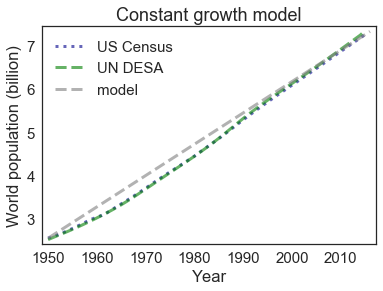

In [38]:
run_simulation1(system)
plot_results(system, title='Constant growth model')

`plot_results` uses `decorate`, which takes parameters that specify the title of the figure, labels for the $x$ and $y$ axis, and limits for the axes.  To read the documentation of `decorate`, run the cells below.

In [39]:
help(decorate)

Help on function decorate in module modsim:

decorate(**kwargs)
    Decorate the current axes.
    
    Call decorate with keyword arguments like
    
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    
    The keyword arguments can be any of the axis properties
    defined by Matplotlib.  To see the list, run plt.getp(plt.gca())
    
    In addition, you can use `legend=False` to suppress the legend.
    
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')



    adjustable = box
    agg_filter = None
    alpha = None
    anchor = C
    animated = False
    aspect = auto
    autoscale_on = True
    autoscalex_on = True
    autoscaley_on = True
    axes = Axes(0.125,0.125;0.775x0.755)
    axes_locator = None
    axis_bgcolor = (1.0, 1.0, 1.0, 1.0)
    axisbelow = True
    children = [<matplotlib.spines.Spine object at 0x000001CEABDB...
    clip_box = None
    clip_on = True
    clip_path = None
    contains = None
    cursor_props = (1, (0.0, 0.0, 0.0, 1))
    data_ratio = 1.0
    default_bbox_extra_artists = [<matplotlib.spines.Spine object at 0x000001CEABDB...
    facecolor = (1.0, 1.0, 1.0, 1.0)
    fc = (1.0, 1.0, 1.0, 1.0)
    figure = Figure(432x288)
    frame_on = True
    geometry = (1, 1, 1)
    gid = None
    images = <a list of 0 AxesImage objects>
    label = 
    legend = None
    legend_handles_labels = ([], [])
    lines = <a list of 0 Line2D objects>
    navigate = True
    navigate_mode = None
    path_effects = []
    picke

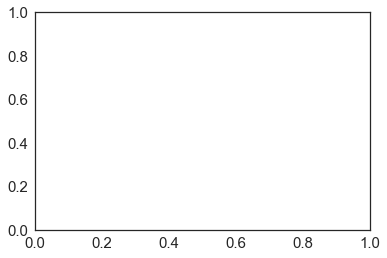

In [40]:
plt.getp(plt.gca())

**Exercise:** The constant growth model doesn't make a lot of sense, because it seems like the number of deaths and births should depend on the size of the population.  As a small improvement, let's write a version of `run_simulation1` where the number of deaths is proportional to the size of the population, but the number of births is constant.  This model doesn't make a lot of sense, either, but it's a good exercise.

Write a function called `run_simulation1b` that implements a model where the number of births is constant, but the number of deaths is proportional to the current size of the population.  Set the death rate to `0.01`, which means that 1% of the population dies each year; then choose the number of annual births to make the model fit the data as well as you can.

Hint: It probably won't fit very well.

In [41]:
# Solution goes here
def run_simulation1b(system, death_rate):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth - (results[t] * death_rate)
    system.results = results

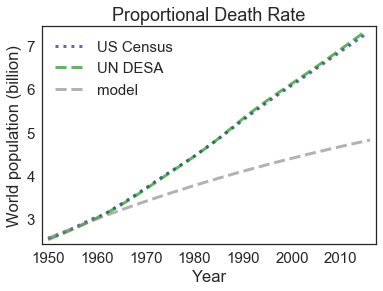

In [42]:
# Solution goes here
run_simulation1b(system, 0.01)
plot_results(system, 'Proportional Death Rate')

## Proportional death, proportional birth

Now let's get to a more realistic model where the number of births and deaths is proportional to the current population.

In [43]:
def run_simulation2(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
    system.results = results

I kept the death rate at 1% and chose the birth rate to fit the data.

In [44]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap03-fig03.pdf


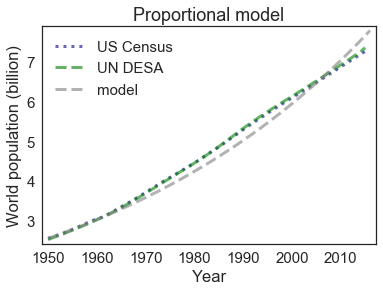

In [45]:
run_simulation2(system)
plot_results(system, title='Proportional model')
savefig('chap03-fig03.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

**Exercise:** In this implementation, we compute the number of deaths and births separately, but since they are both proportional to the current population, we can combine them.

Write a function called `run_simulation2b` that implements a model with a single parameter, `alpha`, that represents the net growth rate, which is the difference between the birth and death rates.  For example, if `alpha=0.01`, the population should grow by 1% per year.

Choose the value of `alpha` that fits the data best.

In [46]:
# Solution goes here
def run_simulation2(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
    system.results = results
def run_simulation2b(sytem, alpha):
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + (alpha * results[t])
    system.results = results

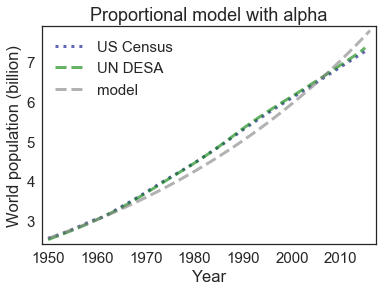

In [47]:
# Solution goes here
run_simulation2b(system, alpha=.017)
plot_results(system, title='Proportional model with alpha')

### Factoring out the update function

The functions that run the model all look the same except the body of the loop.  So we can factor that part out into a function.

In [48]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print(pop)
    print(t)
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

Now the name `update_func1` refers to a function object.

In [49]:
update_func1

<function __main__.update_func1>

Which we can confirm by checking its type.

In [50]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [51]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results

Here's how we use it.

In [52]:
run_simulation(system, update_func1)

2.557628654
1950.0
2.60110834112
1951.0
2.64532718292
1952.0
2.69029774503
1953.0
2.73603280669
1954.0
2.78254536441
1955.0
2.8298486356
1956.0
2.87795606241
1957.0
2.92688131547
1958.0
2.97663829783
1959.0
3.02724114889
1960.0
3.07870424842
1961.0
3.13104222065
1962.0
3.1842699384
1963.0
3.23840252735
1964.0
3.29345537032
1965.0
3.34944411161
1966.0
3.40638466151
1967.0
3.46429320075
1968.0
3.52318618517
1969.0
3.58308035032
1970.0
3.64399271627
1971.0
3.70594059245
1972.0
3.76894158252
1973.0
3.83301358942
1974.0
3.89817482044
1975.0
3.96444379239
1976.0
4.03183933686
1977.0
4.10038060559
1978.0
4.17008707588
1979.0
4.24097855617
1980.0
4.31307519163
1981.0
4.38639746988
1982.0
4.46096622687
1983.0
4.53680265273
1984.0
4.61392829783
1985.0
4.69236507889
1986.0
4.77213528523
1987.0
4.85326158508
1988.0
4.93576703202
1989.0
5.01967507157
1990.0
5.10500954779
1991.0
5.1917947101
1992.0
5.28005522017
1993.0
5.36981615891
1994.0
5.46110303361
1995.0
5.55394178519
1996.0
5.64835879553
1997

Remember not to put parentheses after `update_func1`.  What happens if you try?

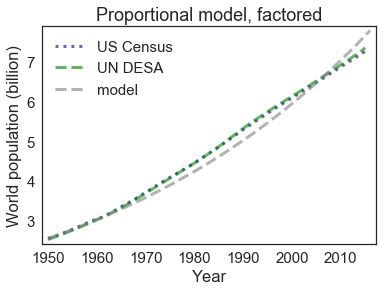

In [53]:
plot_results(system, title='Proportional model, factored')

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [54]:
def update_func1b(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

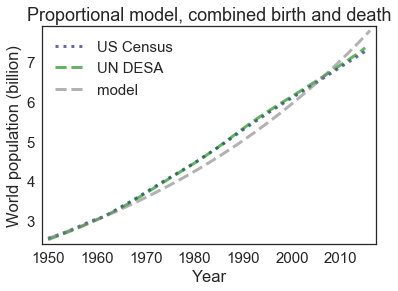

In [55]:
system.alpha = system.birth_rate - system.death_rate

run_simulation(system, update_func1b)
plot_results(system, title='Proportional model, combined birth and death')

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, might be changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write a function called `update_func1c` that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contains two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should compute and return the simulated population one year later.

Note: Don't forget the `return` statement.

In [56]:
# Solution goes here
def update_func1c(pop, t, system):
    if t<1980:
        system.alpha1 = system.birth_rate - system.death_rate
        system.alpha = system.alpha1
    else:
        system.alpha2 = system.birth_rate - system.death_rate
        system.alpha = system.alpha2
    net_growth = system.alpha  * pop
    return pop + net_growth

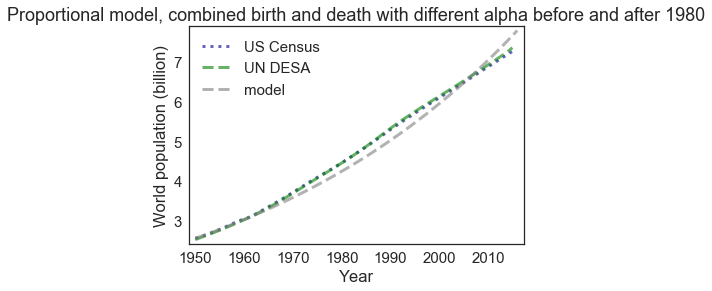

In [57]:
# Solution goes here
run_simulation(system, update_func1c)
plot_results(system, title='Proportional model, combined birth and death with different alpha before and after 1980')

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [58]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

And here are the results.  Can you find values for the parameters that make the model fit better?

Saving figure to file chap03-fig04.pdf


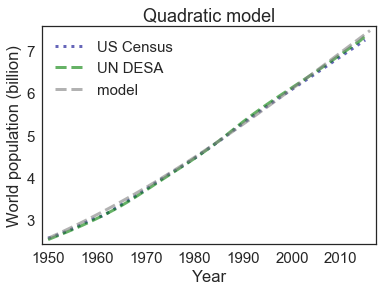

In [59]:
system.alpha = 0.025
system.beta = -0.0018

run_simulation(system, update_func2)
plot_results(system, title='Quadratic model')
savefig('chap03-fig04.pdf')

To understand the quadratic model better, let's plot net growth as a function of population.

In [60]:
pop_array = linspace(0.001, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2

Here's what it looks like.  Remember that the x axis is population now, not time.

The function `sns.set` sets the style for the plots.  I added a grid to this one to make it easier to read.

Saving figure to file chap03-fig05.pdf


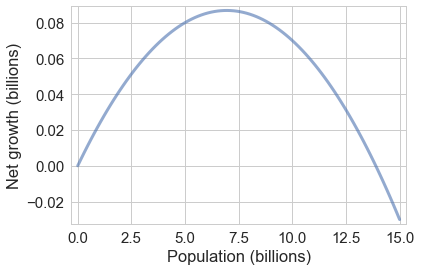

In [61]:
newfig()
sns.set(style='whitegrid', font_scale=1.5)
plot(pop_array, net_growth_array, '-')
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)',
         legend=False)
savefig('chap03-fig05.pdf')

Using `sns.set` to reset the plot style.

In [62]:
sns.set(style='white', font_scale=1.5)

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [63]:
-system.alpha / system.beta

13.88888888888889

This is the equilibrium the population tends toward.

**Exercise:** In the book, I presented a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func2` that implements this version of the model.  Test it by computing system variables `r` and `K` equivalent to `alpha` and `beta`, and confirm that you get the same results. 

In [71]:
# Solution goes here
system.r = system.alpha
system.K = -system.alpha/system.beta
system.r, system.K

(0.025, 13.88888888888889)

In [74]:
# Solution goes here
def update_func2b(pop, t, system):
    delta_p = system.r * pop * (1 - pop / system.K)
    return delta_p + pop

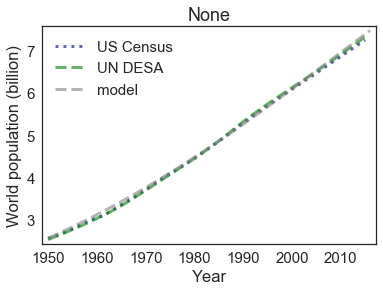

In [75]:
# Solution goes here
run_simulation(system, update_func2b)
plot_results(system)

**Exercise:** On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations.  The following cells process this table and plot some of the results.

Select `table1`, which is the second table on the page.

In [76]:
table1 = tables[1]
table1.head()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.0,NaN,NaN,5.,NaN,NaN,NaN,NaN,NaN,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


Not all agencies and researchers provided estimates for the same dates.  Again `NaN` is the special value that indicates missing data.

In [77]:
table1.tail()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
1913,NaN,NaN,1793.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,1860.0,1863.,1912.,NaN,NaN,NaN,NaN,NaN,1968.
1925,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN
1930,NaN,2070.0,NaN,2092.,NaN,NaN,NaN,NaN,NaN,2145.
1940,NaN,2300.0,2299.,2307.,NaN,NaN,NaN,NaN,NaN,2340.


Some of the estimates are in a form we can't read as numbers.  We could clean them up by hand, but for simplicity I'll replace any value that has an `M` in it with `NaN`.

In [78]:
table1.replace('M', np.nan, regex=True, inplace=True)

Again, we'll replace the long column names with more convenient abbreviations.

In [79]:
table1.columns = ['prb', 'un', 'maddison', 'hyde', 'tanton', 
                  'biraben', 'mj', 'thomlinson', 'durand', 'clark']

This function plots selected estimates.

In [80]:
def plot_prehistory(table):
    """Plots population estimates.
    
    table: DataFrame
    """
    plot(table.prb, 'ro', label='PRB')
    plot(table.un, 'co', label='UN')
    plot(table.hyde, 'yo', label='HYDE')
    plot(table.tanton, 'go', label='Tanton')
    plot(table.biraben, 'bo', label='Biraben')
    plot(table.mj, 'mo', label='McEvedy & Jones')

Here are the results.  Notice that we are working in millions now, not billions.

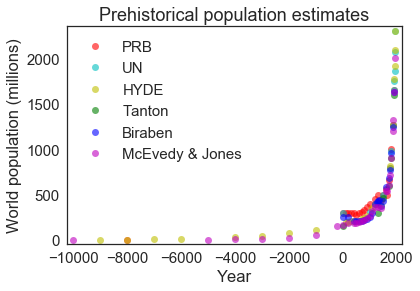

In [81]:
newfig()
plot_prehistory(table1)
decorate(xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')

We can use `xlim` to zoom in on everything after Year 0.

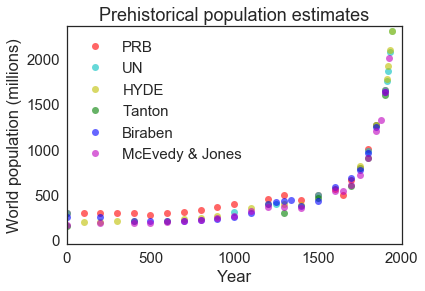

In [82]:
newfig()
plot_prehistory(table1)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')

See if you can find a model that fits these data well from Year -1000 to 1940, or from Year 0 to 1940.

How well does your best model predict actual population growth from 1950 to the present?

In [156]:
# Solution goes here
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot_prehistory(table1)
    plot(system.results, '--', color='gray', label='model')
    decorate(xlim=[0, 2000], xlabel='Year', 
             ylabel='World population (millions)',
             title='Prehistorical population estimates')
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results

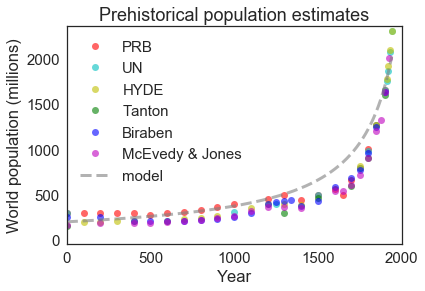

In [157]:
# Solution goes here
prehistoric = System(alpha=0.000005, beta=0.00000231, t0=0, t_end=1940, p0=200)

run_simulation(prehistoric, update_func2)
plot_results(prehistoric, title='Quadratic model')

In [133]:
prehistoric

,value
alpha,0
beta,0
t0,0
t_end,1940
p0,200


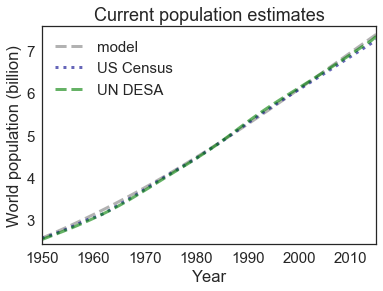

In [164]:
# Solution goes here
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot(system.results, '--', color='gray', label='model')
    decorate(xlim=[1950, 2015], xlabel='Year', 
             ylabel='World population (millions)',
             title='Current population estimates')

run_simulation(system, update_func2)
plot_results(system)
plot_estimates(table2)